# Week3-4: Sentiment Analysis

# 1. Sentiment Analysis with DistilBERT

## Load the DistilBERT Model and Tokenizer

In [1]:
pip install torch transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - torchaudio -> python[version='>=3.13,<3.14.0a0']

Your python: python=3.11

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available

In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1
CUDA available: False


In [4]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Move the model to the specified device
model.to(device)
print("Model loaded successfully!")

Using device: cpu


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model loaded successfully!


In [7]:
import pandas as pd
# Load the cleaned dataset
df = pd.read_csv('cleaned_singapore_airlines_reviews.csv')

# Check the first few rows
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,cleaned_review
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,used airline go singapore london heathrow issu...
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,service singapore airline suite class nothing ...
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,booked paid received email confirmation extra ...
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,best airline world seat food service brilliant...
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,premium economy seating singapore airline narr...


## Preprocess Reviews for Sentiment Analysis

In [8]:
# Function to preprocess the text for DistilBERT
def preprocess_text(text):
    # Tokenize the input text and convert to tensors
    inputs = tokenizer(text, return_tensors='pt', max_length=128, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to the correct device (CPU in your case)
    return inputs

# Apply preprocessing to all reviews in your cleaned dataset
df['inputs'] = df['cleaned_review'].apply(preprocess_text)


## Perform Sentiment Classification

In [9]:
# Function to classify the sentiment of each review
def classify_sentiment(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    # Map the predicted class to sentiment labels
    sentiment_map = {0: 'negative', 1: 'positive'}
    return sentiment_map.get(predicted_class, 'neutral')

# Apply the classification function to each review
df['sentiment'] = df['inputs'].apply(classify_sentiment)

# Display a few rows to check the results
print(df[['cleaned_review', 'sentiment']].head())

# Save the updated DataFrame with sentiment labels to a new CSV file
df.to_csv('classified_reviews_with_sentiment.csv', index=False)
print("Dataset saved as 'classified_reviews_with_sentiment.csv'.")


                                      cleaned_review sentiment
0  used airline go singapore london heathrow issu...  negative
1  service singapore airline suite class nothing ...  positive
2  booked paid received email confirmation extra ...  negative
3  best airline world seat food service brilliant...  positive
4  premium economy seating singapore airline narr...  negative
Dataset saved as 'classified_reviews_with_sentiment.csv'.


## Analyze Sentiment Distribution

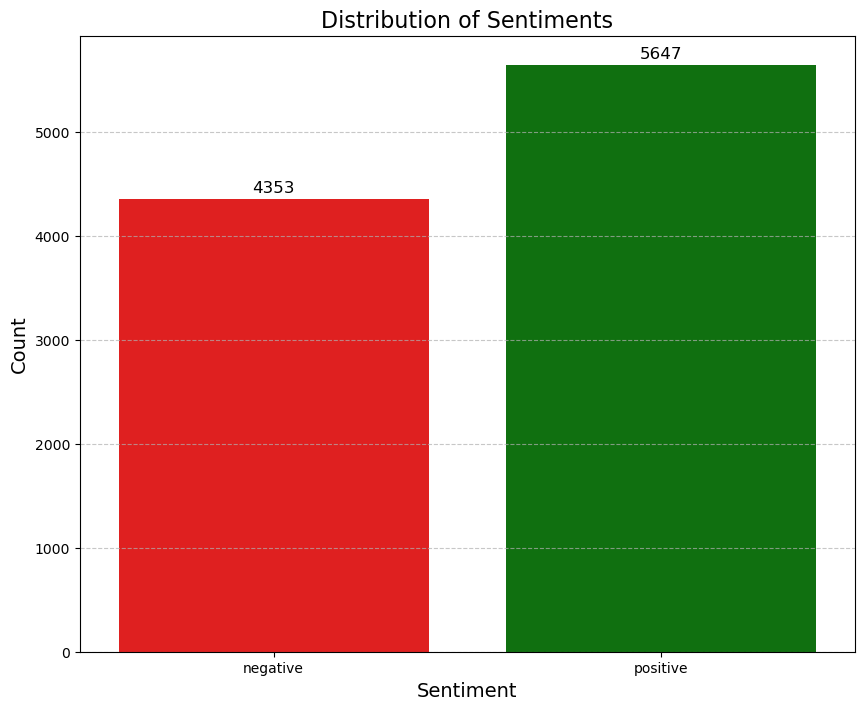

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for positive (green) and negative (red)
colors = {'positive': 'green', 'negative': 'red'}

# Plot the distribution of sentiments
plt.figure(figsize=(10, 8))
ax = sns.countplot(
    x='sentiment', 
    data=df, 
    palette=[colors.get(sentiment) for sentiment in df['sentiment'].unique()]
)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set titles and labels
plt.title('Distribution of Sentiments', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Track Sentiment Shifts Over Time

## Divide the Data into Phases (Pre-COVID, During COVID-19, Post-COVID)

In [13]:
import pandas as pd

# Load the dataset
df = pd.read_csv('classified_reviews_with_sentiment.csv')

# Convert 'published_date' to datetime format with proper handling of timezone information
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

# Remove timezone information to make it timezone-naive
df['published_date'] = df['published_date'].apply(lambda x: x.tz_convert(None) if pd.notnull(x) and x.tzinfo is not None else x)

# Check the conversion
print(df.dtypes)
print(df[['published_date']].head())

published_date        datetime64[ns]
published_platform            object
rating                         int64
type                          object
text                          object
title                         object
helpful_votes                  int64
cleaned_review                object
inputs                        object
sentiment                     object
dtype: object
       published_date
0 2024-03-12 18:41:14
1 2024-03-11 23:39:13
2 2024-03-11 16:20:23
3 2024-03-11 11:12:27
4 2024-03-10 09:34:18


In [14]:
# Define the phases
def determine_phase(date):
    if date < pd.Timestamp('2020-01-01'):
        return 'Pre-COVID'
    elif pd.Timestamp('2020-01-01') <= date <= pd.Timestamp('2021-12-31'):
        return 'During COVID-19'
    else:
        return 'Post-COVID'

# Assign phases to each row
df['phase'] = df['published_date'].apply(determine_phase)

# Check the first few rows
print(df[['published_date', 'phase', 'sentiment']].head(10))

       published_date       phase sentiment
0 2024-03-12 18:41:14  Post-COVID  negative
1 2024-03-11 23:39:13  Post-COVID  positive
2 2024-03-11 16:20:23  Post-COVID  negative
3 2024-03-11 11:12:27  Post-COVID  positive
4 2024-03-10 09:34:18  Post-COVID  negative
5 2024-03-10 06:16:48  Post-COVID  negative
6 2024-03-10 05:54:43  Post-COVID  positive
7 2024-03-09 22:45:56  Post-COVID  negative
8 2024-03-09 04:10:41  Post-COVID  negative
9 2024-03-09 00:18:57  Post-COVID  negative


In [15]:
# Extract year and month for grouping
df['year_month'] = df['published_date'].dt.to_period('M')

In [16]:
# Aggregate the data by 'year_month' and 'sentiment'
monthly_sentiment = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

# Reset the index to convert 'year_month' back to a regular column
monthly_sentiment = monthly_sentiment.reset_index()

# Convert the 'year_month' column back to a timestamp format for plotting
monthly_sentiment['year_month'] = monthly_sentiment['year_month'].dt.to_timestamp()

# Display the aggregated data
print(monthly_sentiment.head())

sentiment year_month  negative  positive
0         2018-08-01       134       181
1         2018-09-01       290       512
2         2018-10-01       165       263
3         2018-11-01       146       233
4         2018-12-01       213       481


## Sentiment Overview Visualisation

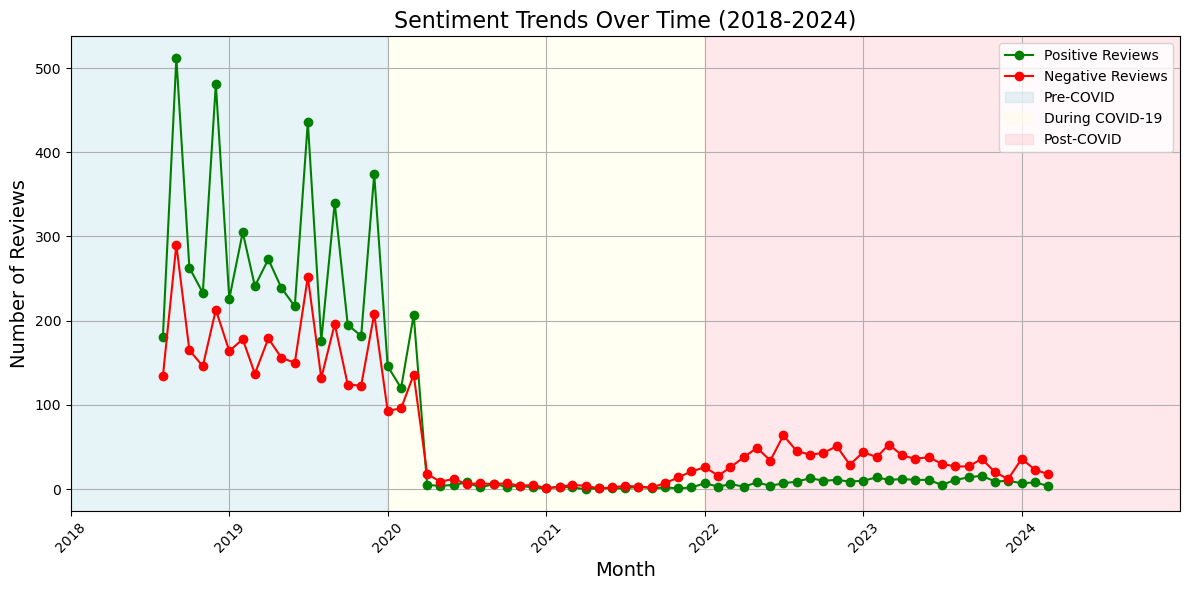

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the line chart with background colors for phases
plt.figure(figsize=(12, 6))

# Plot the positive and negative review counts
plt.plot(monthly_sentiment['year_month'], monthly_sentiment['positive'], label='Positive Reviews', color='green', marker='o', linestyle='-')
plt.plot(monthly_sentiment['year_month'], monthly_sentiment['negative'], label='Negative Reviews', color='red', marker='o', linestyle='-')

# Shade the background to indicate phases
plt.axvspan(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-12-31'), color='lightblue', alpha=0.3, label='Pre-COVID')
plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-12-31'), color='lightyellow', alpha=0.4, label='During COVID-19')
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-12-31'), color='lightpink', alpha=0.3, label='Post-COVID')

# Add titles and labels
plt.title('Sentiment Trends Over Time (2018-2024)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.legend()
plt.grid(True)

# Set x-axis limits and format
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-12-31'))
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# 3. Sentiment Analysis with EST model

## Temporal Sentiment Analysis

In [18]:
# Filter the data based on the phases
pre_covid = df[df['phase'] == 'Pre-COVID']
during_covid = df[df['phase'] == 'During COVID-19']
post_covid = df[df['phase'] == 'Post-COVID']

In [19]:
# Define a function to aggregate data by month and sentiment
def aggregate_sentiment(data):
    data['year_month'] = data['published_date'].dt.to_period('M')
    sentiment_counts = data.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
    sentiment_counts = sentiment_counts.reset_index()
    sentiment_counts['year_month'] = sentiment_counts['year_month'].dt.to_timestamp()
    return sentiment_counts

# Aggregate sentiment data for each phase
pre_covid_agg = aggregate_sentiment(pre_covid)
during_covid_agg = aggregate_sentiment(during_covid)
post_covid_agg = aggregate_sentiment(post_covid)

/var/folders/cn/35wfbzzj6p1cr4nk4t63tbs40000gn/T/ipykernel_42536/3973453328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = data['published_date'].dt.to_period('M')
/var/folders/cn/35wfbzzj6p1cr4nk4t63tbs40000gn/T/ipykernel_42536/3973453328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = data['published_date'].dt.to_period('M')
/var/folders/cn/35wfbzzj6p1cr4nk4t63tbs40000gn/T/ipykernel_42536/3973453328.py:3: SettingWithCopyWarning: 
A value is trying to be s

## Apply Exponential Smoothing (ETS Model)

In [20]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define a function to smooth the data using the ETS model
def smooth_sentiment(data):
    data['positive_smoothed'] = ExponentialSmoothing(data['positive'], trend='add', seasonal=None, seasonal_periods=12).fit().fittedvalues
    data['negative_smoothed'] = ExponentialSmoothing(data['negative'], trend='add', seasonal=None, seasonal_periods=12).fit().fittedvalues
    return data

# Apply the ETS model to each phase
pre_covid_agg = smooth_sentiment(pre_covid_agg)
during_covid_agg = smooth_sentiment(during_covid_agg)
post_covid_agg = smooth_sentiment(post_covid_agg)

## Sentiment Visualisation using Exponential Smoothing (ETS) model

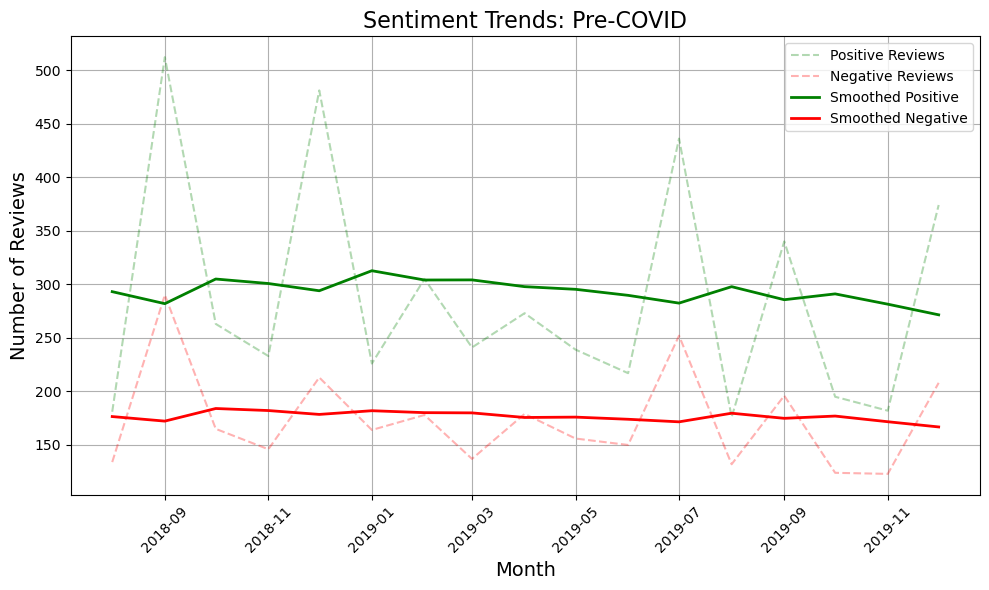

In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def plot_sentiment_trend(data, title):
    plt.figure(figsize=(10, 6))
    
    # Plot the original positive and negative review counts
    plt.plot(data['year_month'], data['positive'], label='Positive Reviews', color='green', alpha=0.3, linestyle='--')
    plt.plot(data['year_month'], data['negative'], label='Negative Reviews', color='red', alpha=0.3, linestyle='--')
    
    # Apply Exponential Smoothing for both positive and negative sentiments
    model_positive = ExponentialSmoothing(data['positive'], trend=None, seasonal=None, seasonal_periods=12)
    model_negative = ExponentialSmoothing(data['negative'], trend=None, seasonal=None, seasonal_periods=12)

    # Fit the models with custom smoothing levels
    smoothed_positive = model_positive.fit(smoothing_level=0.1).fittedvalues
    smoothed_negative = model_negative.fit(smoothing_level=0.1).fittedvalues

    # Plot the smoothed lines
    plt.plot(data['year_month'], smoothed_positive, label='Smoothed Positive', color='green', linewidth=2)
    plt.plot(data['year_month'], smoothed_negative, label='Smoothed Negative', color='red', linewidth=2)
    
    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the trends for each phase
plot_sentiment_trend(pre_covid_agg, 'Sentiment Trends: Pre-COVID')

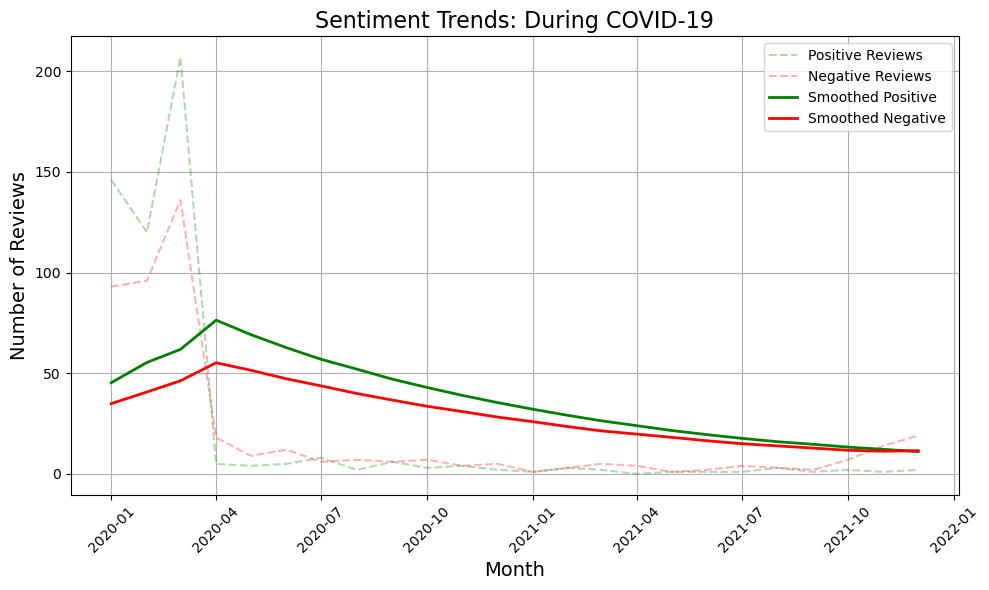

In [23]:
plot_sentiment_trend(during_covid_agg, 'Sentiment Trends: During COVID-19')

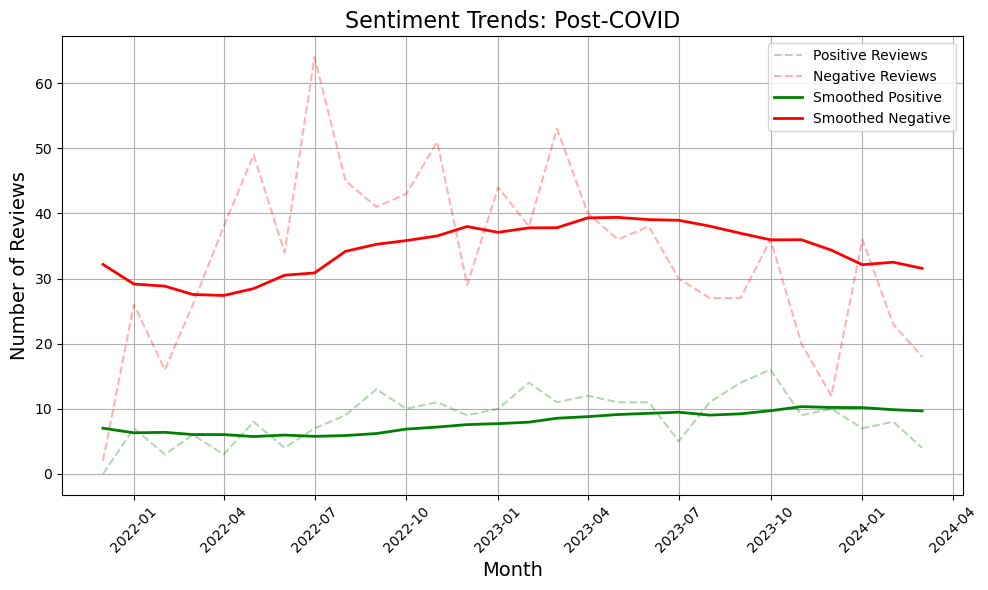

In [24]:
plot_sentiment_trend(post_covid_agg, 'Sentiment Trends: Post-COVID')

## Sentiment Visualisation Overview (EST model)

In [25]:
import pandas as pd

# Add a 'phase' column to each DataFrame
pre_covid_agg['phase'] = 'Pre-COVID'
during_covid_agg['phase'] = 'During COVID-19'
post_covid_agg['phase'] = 'Post-COVID'

# Concatenate the DataFrames
combined_df = pd.concat([pre_covid_agg, during_covid_agg, post_covid_agg], ignore_index=True)

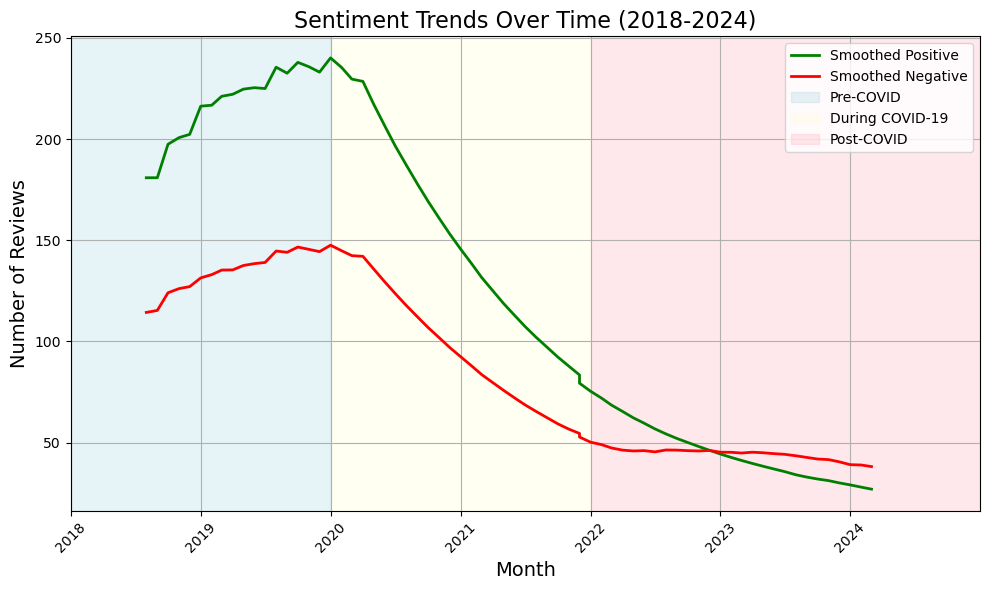

In [26]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def plot_combined_sentiment_trend(data):
    plt.figure(figsize=(10, 6))
    
    # Apply Exponential Smoothing for both positive and negative sentiments
    model_positive = ExponentialSmoothing(data['positive'], trend=None, seasonal=None, seasonal_periods=12)
    model_negative = ExponentialSmoothing(data['negative'], trend=None, seasonal=None, seasonal_periods=12)
    
    # Fit the models with a custom smoothing level
    smoothed_positive = model_positive.fit(smoothing_level=0.05).fittedvalues
    smoothed_negative = model_negative.fit(smoothing_level=0.05).fittedvalues
    
    # Plot the smoothed lines
    plt.plot(data['year_month'], smoothed_positive, label='Smoothed Positive', color='green', linewidth=2)
    plt.plot(data['year_month'], smoothed_negative, label='Smoothed Negative', color='red', linewidth=2)
    
    # Shade the background for different phases
    plt.axvspan(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-12-31'), color='lightblue', alpha=0.3, label='Pre-COVID')
    plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-12-31'), color='lightyellow', alpha=0.4, label='During COVID-19')
    plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-12-31'), color='lightpink', alpha=0.3, label='Post-COVID')
    
    # Set x-axis limits to remove the extra white space
    plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-12-31'))
    
    # Add titles and labels
    plt.title('Sentiment Trends Over Time (2018-2024)', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the combined data
plot_combined_sentiment_trend(combined_df)

## Remove unnecessary columns

In [27]:
# Load the dataset
df = pd.read_csv('classified_reviews_with_sentiment.csv')

# Display the current columns
print("Original Columns:", df.columns)


Original Columns: Index(['published_date', 'published_platform', 'rating', 'type', 'text',
       'title', 'helpful_votes', 'cleaned_review', 'inputs', 'sentiment'],
      dtype='object')


In [28]:
# Select only the columns needed
df_reduced = df[['published_date', 'text', 'cleaned_review', 'sentiment']]

In [29]:
# Save the reduced DataFrame to a new CSV file
df_reduced.to_csv('simplified_reviews_with_sentiment.csv', index=False)

print("Saved cleaned file as 'simplified_reviews_with_sentiment.csv'")

Saved cleaned file as 'simplified_reviews_with_sentiment.csv'


# Week5: dentifying Frequently Used Keywords

In [148]:
import pandas as pd

# Load the simplified dataset
df = pd.read_csv('simplified_reviews_with_sentiment.csv')

# Display the first few rows
print(df.head())

              published_date  \
0  2024-03-12T14:41:14-04:00   
1  2024-03-11T19:39:13-04:00   
2  2024-03-11T12:20:23-04:00   
3  2024-03-11T07:12:27-04:00   
4  2024-03-10T05:34:18-04:00   

                                                text  \
0  We used this airline to go from Singapore to L...   
1  The service on Singapore Airlines Suites Class...   
2  Booked, paid and received email confirmation f...   
3  Best airline in the world, seats, food, servic...   
4  Premium Economy Seating on Singapore Airlines ...   

                                      cleaned_review sentiment  
0  used airline go singapore london heathrow issu...  negative  
1  service singapore airline suite class nothing ...  positive  
2  booked paid received email confirmation extra ...  negative  
3  best airline world seat food service brilliant...  positive  
4  premium economy seating singapore airline narr...  negative  


## Segment the Data by Sentiment and Phase

In [149]:
# Segment the dataset by phase and sentiment
pre_covid_positive = df[(df['sentiment'] == 'positive') & (df['published_date'] < '2020-01-01')]
pre_covid_negative = df[(df['sentiment'] == 'negative') & (df['published_date'] < '2020-01-01')]

during_covid_positive = df[(df['sentiment'] == 'positive') & (df['published_date'] >= '2020-01-01') & (df['published_date'] <= '2021-12-31')]
during_covid_negative = df[(df['sentiment'] == 'negative') & (df['published_date'] >= '2020-01-01') & (df['published_date'] <= '2021-12-31')]

post_covid_positive = df[(df['sentiment'] == 'positive') & (df['published_date'] > '2021-12-31')]
post_covid_negative = df[(df['sentiment'] == 'negative') & (df['published_date'] > '2021-12-31')]

## Extract Frequently Mentioned Keywords

In [150]:
from collections import Counter

# Define additional stopwords specific to airlines
custom_stopwords = set(["flight", "airline", "singapore", "flights", "travel", "seat", "service", "class", "staff"])

# Function to extract top keywords excluding custom stopwords
def extract_keywords(reviews):
    all_words = []
    for review in reviews:
        # Assuming `cleaned_review` is preprocessed and tokenized
        words = review.split()  # Split tokenized text into words
        words = [word for word in words if word not in custom_stopwords]  # Remove custom stopwords
        all_words.extend(words)
    return Counter(all_words).most_common(20)

# Extract keywords for each segment
pre_covid_positive_keywords = extract_keywords(pre_covid_positive['cleaned_review'])
pre_covid_negative_keywords = extract_keywords(pre_covid_negative['cleaned_review'])

during_covid_positive_keywords = extract_keywords(during_covid_positive['cleaned_review'])
during_covid_negative_keywords = extract_keywords(during_covid_negative['cleaned_review'])

post_covid_positive_keywords = extract_keywords(post_covid_positive['cleaned_review'])
post_covid_negative_keywords = extract_keywords(post_covid_negative['cleaned_review'])

# Display results
print("Pre-COVID Positive Keywords:", pre_covid_positive_keywords)
print("Pre-COVID Negative Keywords:", pre_covid_negative_keywords)
print("During COVID-19 Positive Keywords:", during_covid_positive_keywords)
print("During COVID-19 Negative Keywords:", during_covid_negative_keywords)
print("Post-COVID Positive Keywords:", post_covid_positive_keywords)
print("Post-COVID Negative Keywords:", post_covid_negative_keywords)

Pre-COVID Positive Keywords: [('good', 2954), ('food', 2672), ('great', 1760), ('time', 1738), ('crew', 1477), ('comfortable', 1437), ('always', 1315), ('excellent', 1262), ('economy', 1251), ('entertainment', 1117), ('meal', 1076), ('best', 1025), ('fly', 1010), ('cabin', 983), ('experience', 959), ('friendly', 920), ('one', 880), ('would', 843), ('plane', 816), ('first', 813)]
Pre-COVID Negative Keywords: [('food', 1812), ('time', 1620), ('economy', 1515), ('good', 1330), ('one', 1169), ('meal', 1154), ('hour', 1098), ('would', 1038), ('business', 958), ('sq', 881), ('get', 881), ('u', 865), ('crew', 850), ('plane', 828), ('leg', 768), ('back', 765), ('could', 725), ('even', 698), ('premium', 695), ('passenger', 684)]
During COVID-19 Positive Keywords: [('good', 304), ('food', 289), ('time', 209), ('crew', 200), ('great', 196), ('cabin', 189), ('comfortable', 176), ('passenger', 168), ('business', 167), ('meal', 159), ('one', 148), ('economy', 136), ('excellent', 130), ('entertainmen

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word clouds with custom colors and improved titles
def generate_wordcloud(words, title, color):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap=color  # Specify the color map (Greens for positive, Reds for negative)
    ).generate_from_frequencies(dict(words))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Enhanced title style
    plt.title(title, fontsize=20, weight='bold', color='black', pad=20)
    plt.show()


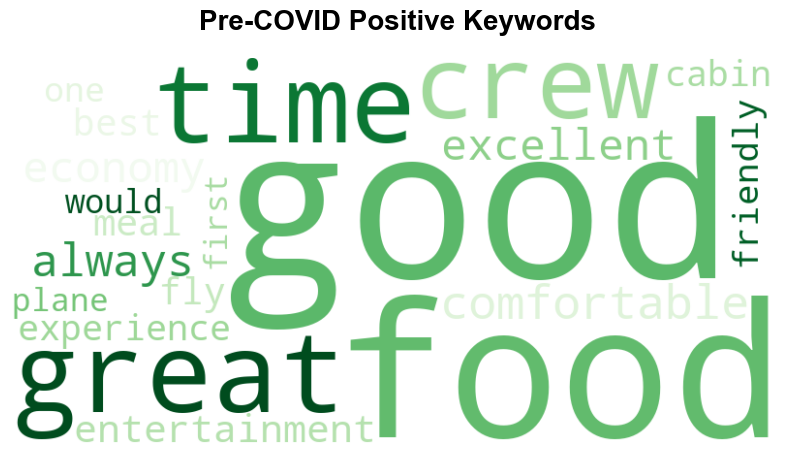

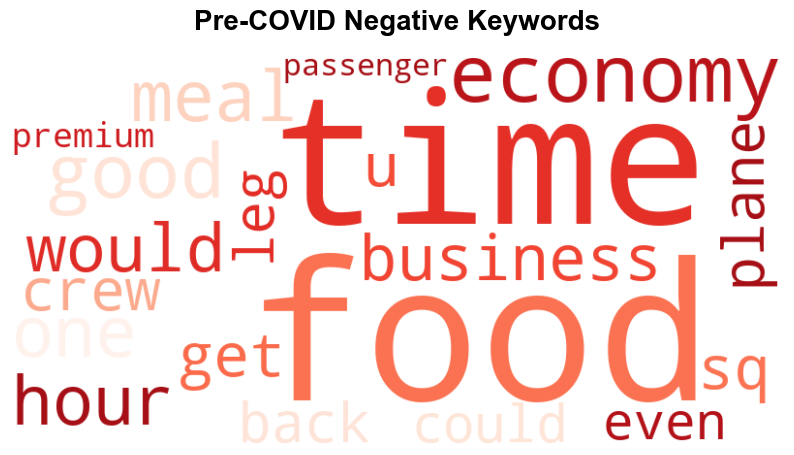

In [152]:
# Generate word clouds for positive and negative sentiments
generate_wordcloud(pre_covid_positive_keywords, 'Pre-COVID Positive Keywords', 'Greens')
generate_wordcloud(pre_covid_negative_keywords, 'Pre-COVID Negative Keywords', 'Reds')

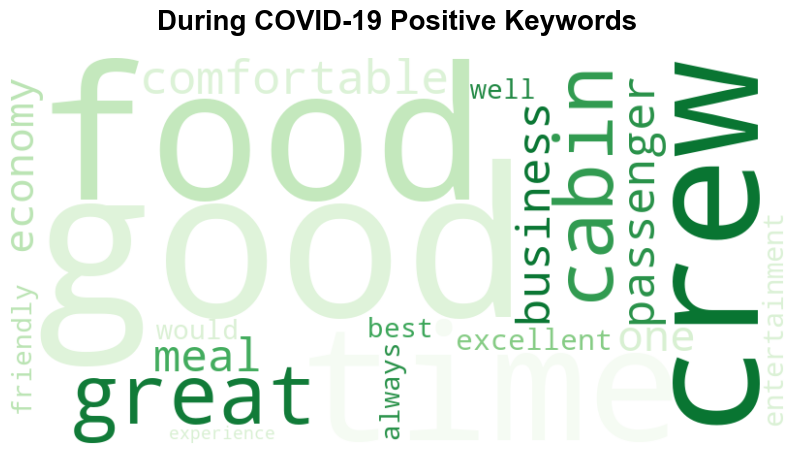

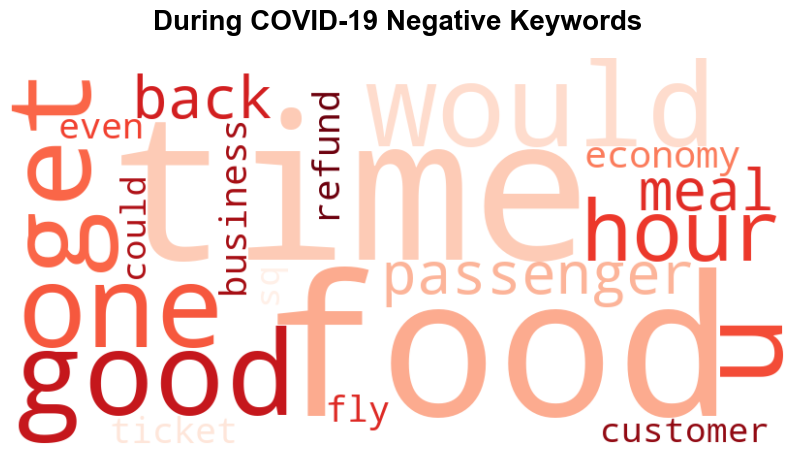

In [153]:
generate_wordcloud(during_covid_positive_keywords, 'During COVID-19 Positive Keywords', 'Greens')
generate_wordcloud(during_covid_negative_keywords, 'During COVID-19 Negative Keywords', 'Reds')

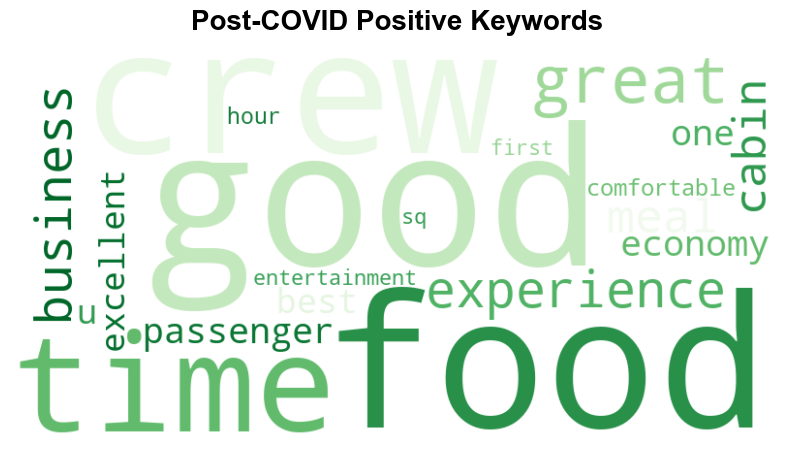

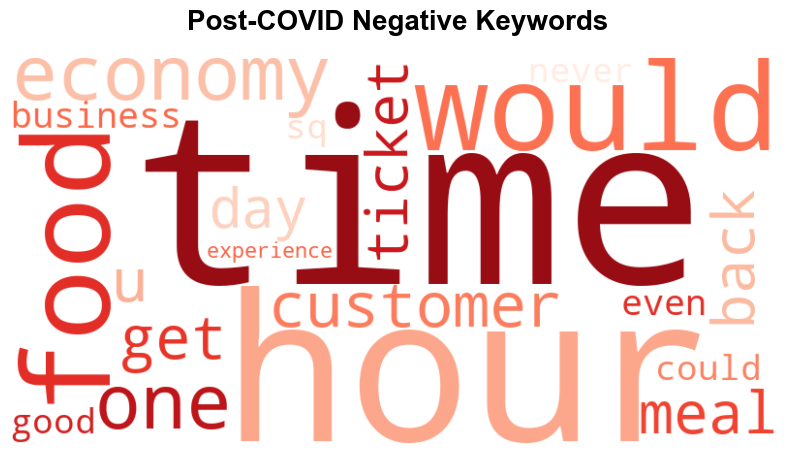

In [154]:
generate_wordcloud(post_covid_positive_keywords, 'Post-COVID Positive Keywords', 'Greens')
generate_wordcloud(post_covid_negative_keywords, 'Post-COVID Negative Keywords', 'Reds')

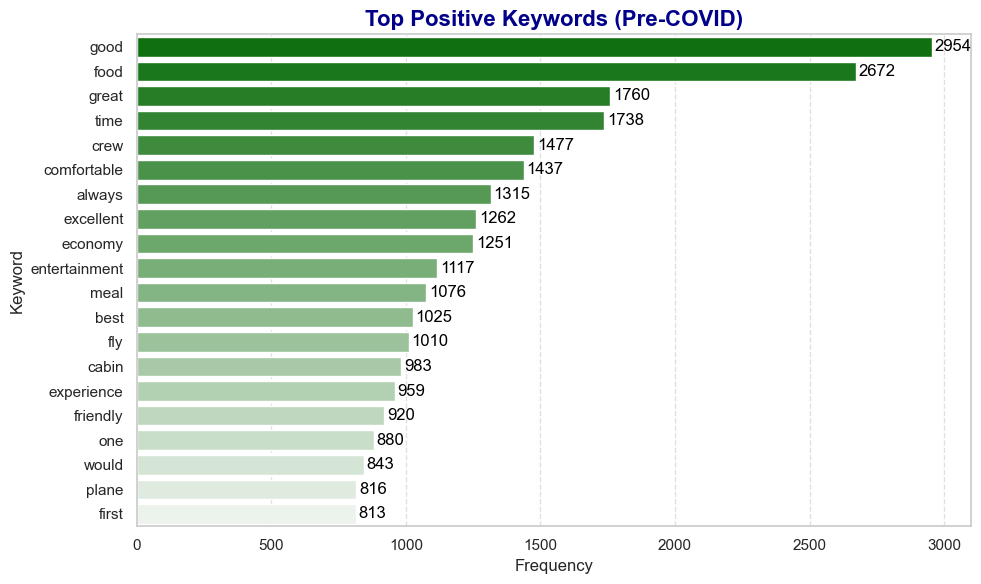

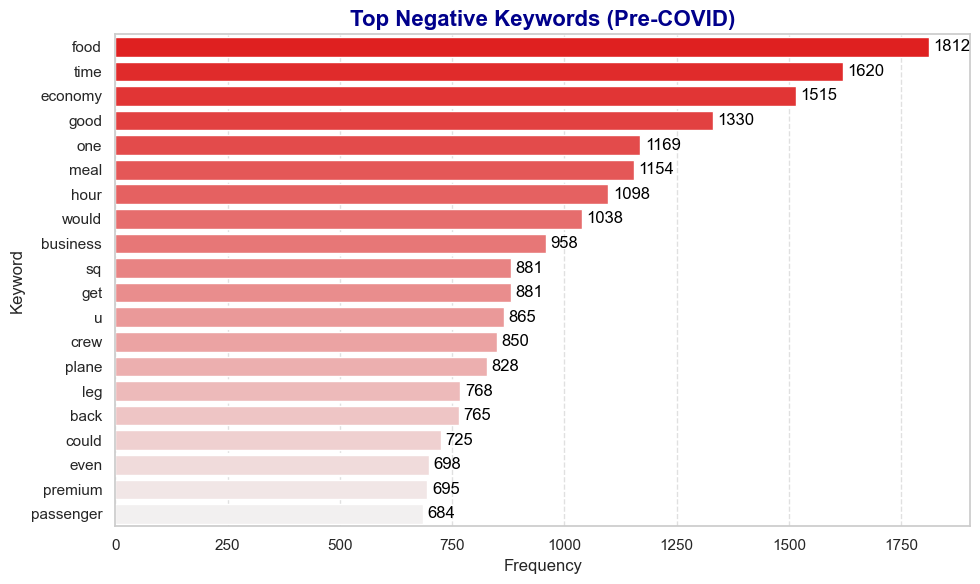

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot bar charts for keywords with improved color scheme
def plot_keywords_bar(keywords, title, color):
    # Convert the keyword list to a DataFrame
    keywords_df = pd.DataFrame(keywords, columns=['Keyword', 'Frequency'])
    
    plt.figure(figsize=(10, 6))
    
    # Use a sequential color palette that goes from light to dark
    barplot = sns.barplot(
        x='Frequency', 
        y='Keyword', 
        data=keywords_df, 
        palette=sns.light_palette(color, n_colors=len(keywords), reverse=True)
    )
    
    # Add value labels to each bar
    for index, value in enumerate(keywords_df['Frequency']):
        barplot.text(value + 10, index, str(value), color='black', va='center')
    
    # Improve the title visibility
    plt.title(title, fontsize=16, weight='bold', color='darkblue')
    plt.xlabel('Frequency')
    plt.ylabel('Keyword')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot bar charts for each phase with the improved function
plot_keywords_bar(pre_covid_positive_keywords, 'Top Positive Keywords (Pre-COVID)', 'green')  # Dark green
plot_keywords_bar(pre_covid_negative_keywords, 'Top Negative Keywords (Pre-COVID)', 'red')  # Dark red

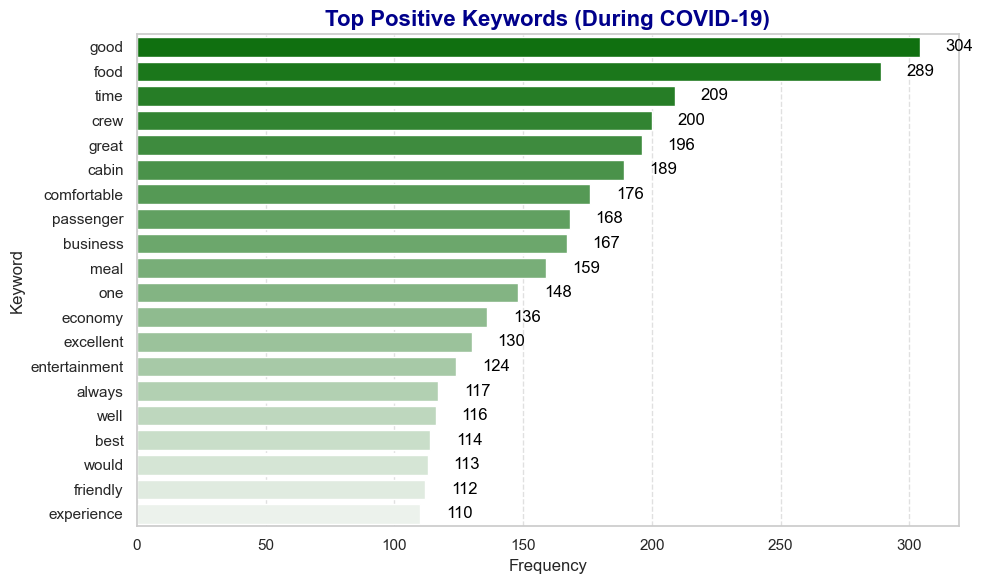

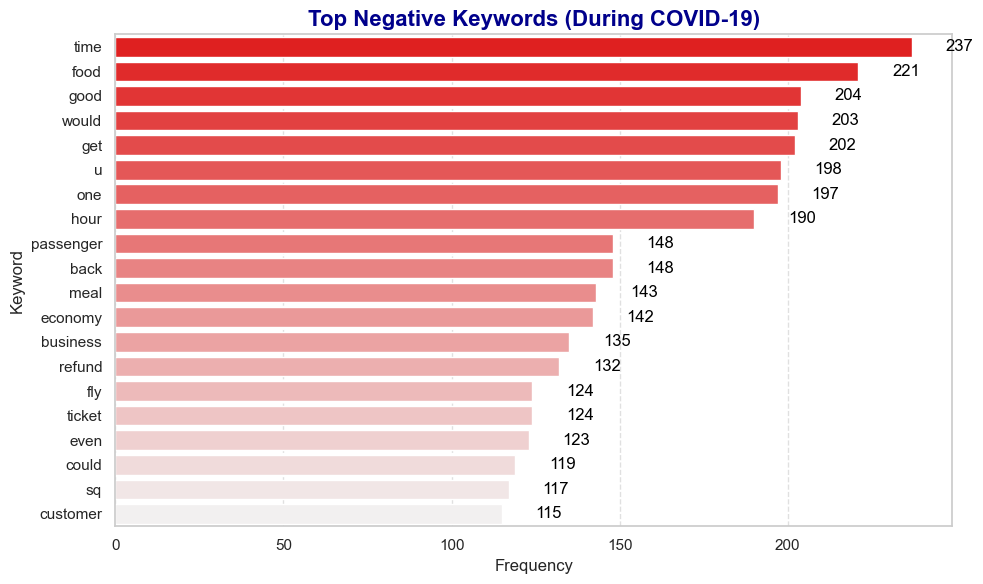

In [164]:
plot_keywords_bar(during_covid_positive_keywords, 'Top Positive Keywords (During COVID-19)', 'green')
plot_keywords_bar(during_covid_negative_keywords, 'Top Negative Keywords (During COVID-19)', 'red')

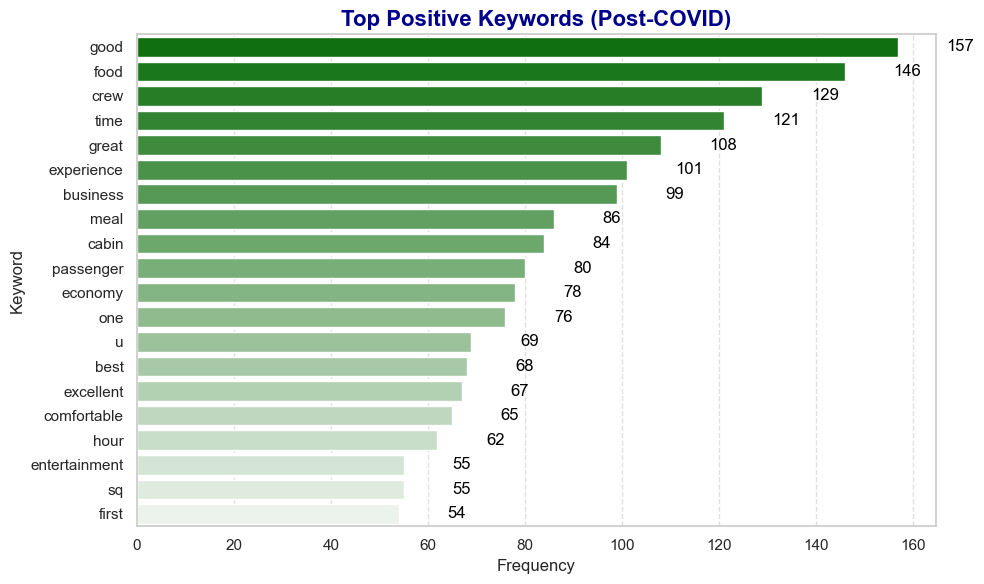

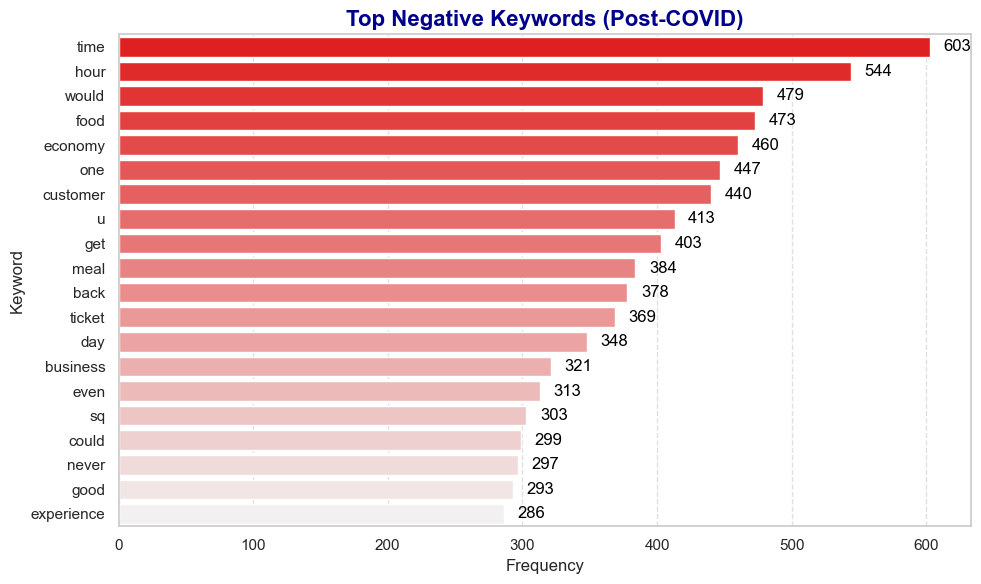

In [165]:
plot_keywords_bar(post_covid_positive_keywords, 'Top Positive Keywords (Post-COVID)', 'green')
plot_keywords_bar(post_covid_negative_keywords, 'Top Negative Keywords (Post-COVID)', 'red')